# Import packages

In [1]:
import os
import gc
import pandas as pd
import numpy as np
import _pickle as cPickle

# Make automatically EDA
#from ydata_profiling import ProfileReport

# Visualization
import matplotlib.pyplot as plt

# Statistic
#import statsmodels.api as sm

# Machine Learning framework
from sklearn.metrics import mean_absolute_error

# Import src modules
from grid_computing_forecasting import database, config, dataset
from grid_computing_forecasting.modeling import predict

# Retrieve data from database

In [2]:
database.retrieve_from_db(config.database_path)

# Load dataset

In [5]:
# Read the Parquet file into a DataFrame
parquet_dataset = os.path.join(config.database_path, "dataset.parquet")
df = pd.read_parquet(parquet_dataset, engine='pyarrow')

# Display the first few rows of the DataFrame
df.head()

,JobID,SubmitTime,WaitTime,RunTime,NProc,UsedCPUTime,UsedMemory,ReqNProcs,ReqTime,ReqMemory,...,JobStructureParams,UsedNetwork,UsedLocalDiskSpace,UsedResources,ReqPlatform,ReqNetwork,ReqLocalDiskSpace,ReqResources,VOID,ProjectID
0,1,1109087545,9,21,1,0.05,8282.112,1,-1.0,-1.0,...,-1,-1.0,-1.0,-1,-1,-1.0,-1.0,-1,-1,-1
1,2,1109087546,8,21,1,0.08,10485.760,1,-1.0,-1.0,...,-1,-1.0,-1.0,-1,-1,-1.0,-1.0,-1,-1,-1
2,3,1109087609,5,1,1,0.00,2584.576,1,-1.0,-1.0,...,-1,-1.0,-1.0,-1,-1,-1.0,-1.0,-1,-1,-1
3,4,1109091229,15,0,1,0.00,0.000,1,-1.0,-1.0,...,-1,-1.0,-1.0,-1,-1,-1.0,-1.0,-1,-1,-1
4,5,1109091214,65162,1,1,0.00,0.000,1,-1.0,-1.0,...,-1,-1.0,-1.0,-1,-1,-1.0,-1.0,-1,-1,-1


# Pre-processing

## Exploratory Data Analysis (EDA)

In [ ]:
# Generate the profile report
profile = ProfileReport(df, title='EDA', html={'style':{'full_width':True}})
profile.to_notebook_iframe()
eda_report_path = os.path.join(config.root_dir, "reports/exploratory-data-analysis.html")
profile.to_file(output_file=eda_report_path)

## Dataset Cleaning

Exploratory analysis showed us that many features in the dataset consisted of unique values and were therefore not useful. We will simply remove them. Plus, we also have some rows with negatives values, we will remove them too.

In [6]:
df_cleaned_features = dataset.keep_useful_features(df)
df_cleaned_rows = dataset.remove_negative_rows(df_cleaned_features, 'ReqTime')
df_cleaned = df_cleaned_rows
df_cleaned.head()

,SubmitTime,RunTime,ReqNProcs,ReqTime,Status,UserID,GroupID,ExecutableID,QueueID,OrigSiteID,JobStructure
0,1109335071,12,1,600.0,1,U0,G0,X3,Q0,DAS2/fs0,UNITARY
1,1109335417,3,2,960.0,1,U0,G0,X12,Q0,DAS2/fs0,UNITARY
2,1109339940,2,2,960.0,1,U0,G0,X12,Q0,DAS2/fs0,UNITARY
3,1109340315,3,2,960.0,1,U0,G0,X12,Q0,DAS2/fs0,UNITARY
4,1109341407,5,2,960.0,1,U0,G0,X12,Q0,DAS2/fs0,UNITARY


## Dataset filtered

To apply our approximate aSJN algorithm, we need a history of execution times for completed jobs. Therefore, we will only retain the jobs that have a "Status" == 1.

In [7]:
df_finished_jobs = dataset.keep_finished_jobs(df_cleaned, 'Status')
df_finished_jobs.head()

,SubmitTime,RunTime,ReqNProcs,ReqTime,UserID,GroupID,ExecutableID,QueueID,OrigSiteID,JobStructure
0,1109335071,12,1,600.0,U0,G0,X3,Q0,DAS2/fs0,UNITARY
1,1109335417,3,2,960.0,U0,G0,X12,Q0,DAS2/fs0,UNITARY
2,1109339940,2,2,960.0,U0,G0,X12,Q0,DAS2/fs0,UNITARY
3,1109340315,3,2,960.0,U0,G0,X12,Q0,DAS2/fs0,UNITARY
4,1109341407,5,2,960.0,U0,G0,X12,Q0,DAS2/fs0,UNITARY


Some ultra-fast jobs have their values set to 0. This can skew the results. Therefore, we remove these jobs from our dataframe.

In [8]:
df_non_zero_runtime = dataset.filter_non_zero_runtime(df_finished_jobs)
df_non_zero_runtime.head()

,SubmitTime,RunTime,ReqNProcs,ReqTime,UserID,GroupID,ExecutableID,QueueID,OrigSiteID,JobStructure
0,1109335071,12,1,600.0,U0,G0,X3,Q0,DAS2/fs0,UNITARY
1,1109335417,3,2,960.0,U0,G0,X12,Q0,DAS2/fs0,UNITARY
2,1109339940,2,2,960.0,U0,G0,X12,Q0,DAS2/fs0,UNITARY
3,1109340315,3,2,960.0,U0,G0,X12,Q0,DAS2/fs0,UNITARY
4,1109341407,5,2,960.0,U0,G0,X12,Q0,DAS2/fs0,UNITARY


To save CPU resources we will only study the top 10 users

In [9]:
df_top_n_app = dataset.filter_top_n_apps(df_non_zero_runtime, 10)
df_top_n_app.head()

,SubmitTime,RunTime,ReqNProcs,ReqTime,UserID,GroupID,ExecutableID,QueueID,OrigSiteID,JobStructure
531,1110905773,17,2,960.0,U0,G0,X17,Q0,DAS2/fs0,UNITARY
532,1110905808,10,4,960.0,U0,G0,X17,Q0,DAS2/fs0,UNITARY
533,1110906267,13,4,960.0,U0,G0,X17,Q0,DAS2/fs0,UNITARY
538,1111501485,2,1,60.0,U1,G1,X14,Q0,DAS2/fs0,UNITARY
539,1111504861,1,1,60.0,U1,G1,X14,Q0,DAS2/fs0,UNITARY


## Remove outliers

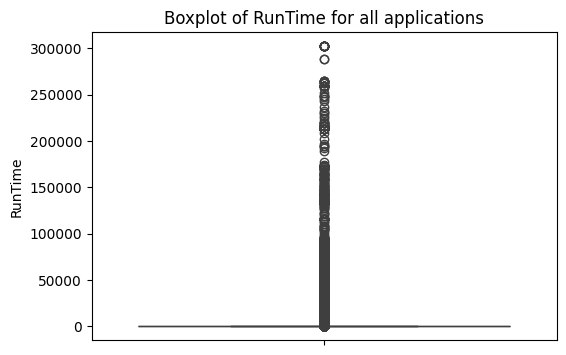

In [12]:
# Plot boxplots with outliers
dataset.plot_boxplot(
    df_top_n_app,
    'RunTime',
    config.root_dir,
    "reports/boxplot_with_outliers.png"
)

Unfortunately, we do not have enough jobs for each applications that would have allowed us to analyze the jobs with more precision. Here, we are limited to looking at jobs by aggregated all jobs together. However, a single user can launch jobs for different clients, each with different characteristics (e.g., "RunTime", etc.), and this will affect our benchmark, which is based on the median. Indeed, jobs from different applications will have varying "RunTime", leading to high variance for each "UserID". This can be observed in the boxplots above, where many outliers distort the distribution of our "RunTime" values. To address this, we will simply eliminate the outliers (see boxplots below).

In [13]:
# Remove jobs with outliners
df_remove_outliers = dataset.df_remove_outliers(df_top_n_app, "RunTime")

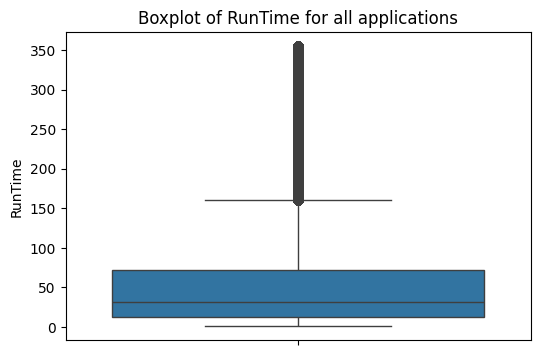

In [14]:
# Plot boxplots without outliers
dataset.plot_boxplot(
    df_remove_outliers,
    'RunTime',
    config.root_dir,
    "reports/boxplot_without_outliers.png"
)

After removing the outliers, we obtain more usable boxplot. Variance has diminished so that median will be probably a good baseline.

## Features engineering

### One Hot Encoder for categorical features

In [15]:
df_ohe = dataset.apply_one_hot_encoding(
    df_remove_outliers,
    ['UserID', 'GroupID', 'ExecutableID', 'QueueID', 'OrigSiteID', 'JobStructure']
)
df_ohe.head()

,SubmitTime,RunTime,ReqNProcs,ReqTime,UserID_U0,UserID_U1,UserID_U10,UserID_U100,UserID_U101,UserID_U102,...,QueueID_Q0,QueueID_Q1,QueueID_Q2,OrigSiteID_DAS2/fs0,OrigSiteID_DAS2/fs1,OrigSiteID_DAS2/fs2,OrigSiteID_DAS2/fs3,OrigSiteID_DAS2/fs4,JobStructure_BoT,JobStructure_UNITARY
531,1110905773,17,2,960.0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
532,1110905808,10,4,960.0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
533,1110906267,13,4,960.0,1,0,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
538,1111501485,2,1,60.0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1
539,1111504861,1,1,60.0,0,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,1


### Split datetime feature

In [16]:
df_split_datetime = dataset.split_datetime(df_ohe)
df_split_datetime.head()

,Timestamp,Year,Month,Day,Hour,Minute,RunTime,ReqNProcs,ReqTime,UserID_U0,...,QueueID_Q0,QueueID_Q1,QueueID_Q2,OrigSiteID_DAS2/fs0,OrigSiteID_DAS2/fs1,OrigSiteID_DAS2/fs2,OrigSiteID_DAS2/fs3,OrigSiteID_DAS2/fs4,JobStructure_BoT,JobStructure_UNITARY
531,2005-03-15 16:56:13,2005,3,15,16,56,17,2,960.0,1,...,1,0,0,1,0,0,0,0,0,1
532,2005-03-15 16:56:48,2005,3,15,16,56,10,4,960.0,1,...,1,0,0,1,0,0,0,0,0,1
533,2005-03-15 17:04:27,2005,3,15,17,4,13,4,960.0,1,...,1,0,0,1,0,0,0,0,0,1
538,2005-03-22 14:24:45,2005,3,22,14,24,2,1,60.0,0,...,1,0,0,1,0,0,0,0,0,1
539,2005-03-22 15:21:01,2005,3,22,15,21,1,1,60.0,0,...,1,0,0,1,0,0,0,0,0,1


## Determination of the seasonality 

We have a dataset ranging from February 25, 2005, to December 13, 2006 (22 months). The temporal nature of our data series should reveal some seasonality (repetition of data that is visually apparent). Thus, we will limit our study to 3 seasonal periods.

In [ ]:
# Data aggregation by day
df_seasonality = dataset.aggregate_by_time(df_ohe[['Timestamp', 'RunTime']], 'Timestamp', 'D')[['Timestamp', 'RunTime']]
df_seasonality.set_index('Timestamp', inplace=True)
df_seasonality.head()

# Decompose the time series using an additive model
decomposition = sm.tsa.seasonal_decompose(df_seasonality['RunTime'], model='additive', period=30)

# Plot the decomposed components
decomposition.plot()

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Save the figure
seasonality_figure_path = os.path.join(config.root_dir, "reports/time-series-seasonality.png")
plt.savefig(seasonality_figure_path, bbox_inches='tight')
plt.show()

Seasonal figure above shows 21 periods spread over 21.5 months. Thus, we deduce a seasonality of one month. For our analysis, we will therefore use 3 periods, which corresponds to 3 months of data.

In [17]:
# Define the date range = 18 months
start_date = '2005-07-01'
end_date = '2006-12-13'

# Filter the rows based on the date range
df_filter_by_date = df_split_datetime[(df_split_datetime['Timestamp'] >= start_date) & (df_split_datetime['Timestamp'] <= end_date)]
df_filter_by_date.head()

,Timestamp,Year,Month,Day,Hour,Minute,RunTime,ReqNProcs,ReqTime,UserID_U0,...,QueueID_Q0,QueueID_Q1,QueueID_Q2,OrigSiteID_DAS2/fs0,OrigSiteID_DAS2/fs1,OrigSiteID_DAS2/fs2,OrigSiteID_DAS2/fs3,OrigSiteID_DAS2/fs4,JobStructure_BoT,JobStructure_UNITARY
39233,2005-07-01 00:00:03,2005,7,1,0,0,16,2,900.0,0,...,1,0,0,1,0,0,0,0,0,1
39234,2005-07-01 00:00:27,2005,7,1,0,0,3,1,960.0,0,...,1,0,0,1,0,0,0,0,0,1
39235,2005-07-01 00:00:44,2005,7,1,0,0,5,1,960.0,0,...,1,0,0,1,0,0,0,0,0,1
39236,2005-07-01 00:00:44,2005,7,1,0,0,5,1,960.0,0,...,1,0,0,1,0,0,0,0,0,1
39237,2005-07-01 00:00:44,2005,7,1,0,0,6,1,960.0,0,...,1,0,0,1,0,0,0,0,0,1


# Method 1: Baseline = median "RunTime"

In [18]:
# Compute the median
median_runtime = df_filter_by_date['RunTime'].median()

# Compute standard deviation
std_runtime = df_filter_by_date['RunTime'].std()

print(f"RunTime median: {median_runtime}")
print(f"RunTime std: {std_runtime}")

RunTime median: 34.0
RunTime std: 70.85867101818874


In [19]:
MAE_for_median = mean_absolute_error(df_filter_by_date['RunTime'], np.full(len(df_filter_by_date), median_runtime))
MAE_for_median

np.float64(46.72664533599274)

# Method 2: Machine Learning models

To apply machine learning models to a time series dataset, we must ensure that the data is in chronological order.

In [20]:
df_ML = dataset.sort_dataframe_by_timestamp(df_filter_by_date)

## XGBoost

In [21]:
# Releasing RAM memory to avoid saturation
del df
del df_cleaned_features
del df_cleaned_rows
del df_cleaned
del df_finished_jobs
del df_non_zero_runtime
del df_top_n_app
del df_remove_outliers
del df_ohe

gc.collect()

1771

### Train XGBoost model

In [ ]:
best_xgboost_model = train.xgboost(
    df_ML,
    config.root_dir,
    "models/xgboost"
)

### Test prediction with XGBoost model

In [22]:
X_test = df_ML.drop(columns=['Timestamp', 'RunTime']).iloc[[900]]
predicted_value = predict.with_xgboost(
    config.root_dir,
    "models/xgboost.pkl",
    X_test
)
predicted_value

/home/hao/Desktop/grid-computing-forecasting/.venv/lib/python3.10/site-packages/xgboost/core.py:158: UserWarning: [17:36:15] WARNING: /workspace/src/collective/../data/../common/error_msg.h:80: If you are loading a serialized model (like pickle in Python, RDS in R) or
configuration generated by an older version of XGBoost, please export the model by calling
`Booster.save_model` from that version first, then load it back in current version. See:

    https://xgboost.readthedocs.io/en/stable/tutorials/saving_model.html

for more details about differences between saving model and serializing.

  warnings.warn(smsg, UserWarning)


np.float32(58.94861)

### Create dataset for API test

In [23]:
df = df_ML.drop(columns=['Timestamp', 'RunTime'])
dataset.create_dataframe_sample(
    df,
    10,
    os.path.join(config.root_dir, "app/backend/"),
    "df_sample.pkl"
)

In [24]:
# Load pickle object for test API
df = dataset.load_pickle_file(
    os.path.join(config.root_dir, "app/backend/df_sample.pkl")
)

## Grownet

In [18]:
# Pre-process dataset to fit grownet model
#df_ML_test = df_ML.head(50000)
#df_ML_grownet = train.grownet(df_ML_test)

train.grownet(df_ML)

### Train Grownet model

In [ ]:
# Train grownet model
!./../src/grid_computing_forecasting/modeling/regression/train.sh

In [ ]:
# Train grownet model
!./../src/grid_computing_forecasting/modeling/regression/train.sh